In [1]:
from numpy import cos, sin, pi, sqrt

deg = pi / 8

x = (
    -((cos(deg) - sin(deg)) / (8 * sin(deg) ** 3))
    + (cos(deg) / sqrt(2))
    -((3 * cos(deg) + sin(deg)) / (8 * cos(deg) ** 3))
    + (cos(deg) / 4)
)
print("x:", x)

y = (
    -((3 * sin(deg) - cos(deg)) / (8 * sin(deg) ** 3))
    + (sin(deg) / sqrt(2))
    -((cos(deg) + sin(deg)) / (8 * cos(deg) ** 3))
    + (sin(deg) / 4)
)
print("y:", y)

x: -0.8228554156205372
y: -0.34083787302217655


# Example: Gaussian Mixture

- 2020-11-29 first uploaded
- 2021-04-08 backward loss updated

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import itertools
from flow import *
from utils import *
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
print(tf.__version__)
!python --version

2023-11-19 08:24:04.823215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
Python 3.10.12


## Settings

In [3]:
n_means = 8
radius = 14
sd = 1
labels = ['red','gold','green','chocolate','blue','magenta','pink','purple']
# labels = ['red','red','red','red','blue','blue','green','purple']
assert len(labels) == n_means

x_dim = 2
y_dim = len(list(set(labels)))
z_dim = 2
tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim
n_sample = 200
n_data = n_sample * n_means
n_couple_layer = 3
n_hid_layer = 3
n_hid_dim = 512

n_batch = 50
n_epoch = 100
n_display = 10

(8, 200, 2)


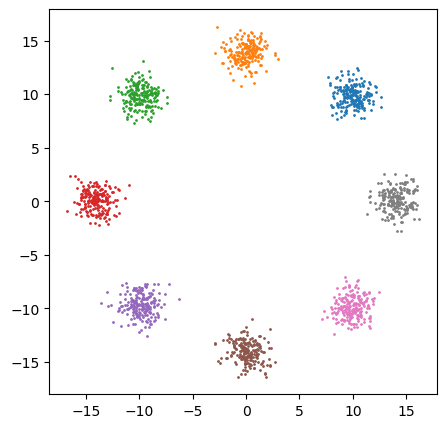

In [4]:
# Make data
X_raw = np.zeros((n_means, n_sample, x_dim), dtype='float32')
for i in range(n_means):
    th = 2*np.pi / n_means * (i+1)
    mean = [radius*np.cos(th), radius*np.sin(th)]
    X_raw[i, :, :] = np.random.multivariate_normal(mean, np.identity(x_dim)*sd, size=n_sample)

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')
for i in range(n_means):
    ax.scatter(X_raw[i,:,0], X_raw[i,:,1], s=1)
print(X_raw.shape)

(1600, 2)


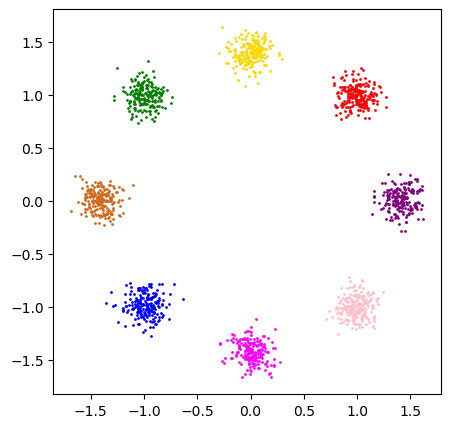

In [5]:
# Preprocess
uq_labels = list(set(labels))
idx2lab = {i:lab for i, lab in enumerate(uq_labels)}
lab2idx = {idx2lab[key]:i for i, key in enumerate(idx2lab.keys())}

X = X_raw.reshape((-1, x_dim))
print(X.shape)
X = StandardScaler().fit_transform(X)
y = [[lab2idx[lab]]*n_sample for lab in labels]
y = list(itertools.chain.from_iterable(y)) # flatten
y_onehot = np.eye(len(uq_labels))[y].astype('int')

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y]
    ax.scatter(X[idx,0], X[idx,1], s=1, c=color)

In [6]:
# Pad data
pad_x = np.zeros((X.shape[0], pad_dim))
x_data = np.concatenate([X, pad_x], axis=-1).astype('float32')
z = np.random.multivariate_normal([0.]*z_dim, np.eye(z_dim), X.shape[0]).astype('float32')
print(x_data.shape)
print(y_onehot.shape)
print(z.shape)
y_data = np.concatenate([z, y_onehot], axis=-1).astype('float32')

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x_data)
y_data = tf.data.Dataset.from_tensor_slices(y_data)
dataset = (tf.data.Dataset.zip((x_data, y_data))
           .shuffle(buffer_size=X.shape[0])
           .batch(n_batch, drop_remainder=True)
           .repeat())

(1600, 10)
(1600, 8)
(1600, 2)


2023-11-19 08:24:11.913344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-19 08:24:11.914868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


## Initialize the model

In [7]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name='NVP')
x = tfk.Input((tot_dim,))
model(x);
model.summary()
# tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True, dpi=64)

Model: "NVP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer0 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
 Layer1 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
 Layer2 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
Total params: 3201114 (12.21 MB)
Trainable params: 3201084 (12.21 MB)
Non-trainable params: 30 (240.00 Byte)
_________________________________________________________________


In [8]:
class Trainer(tfk.Model):
    def __init__(self, model, x_dim, y_dim, z_dim, tot_dim, 
                 n_couple_layer, n_hid_layer, n_hid_dim, shuffle_type='reverse'):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = 5.
        self.w2 = 1.
        self.w3 = 10.
        self.loss_factor = 1.
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MMD_multiscale

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, :self.x_dim]
        y = y_data[:, -self.y_dim:]
        z = y_data[:, :self.z_dim]
        print("x", x.shape)
        print("y", y.shape)
        print("z", z.shape)
        y_short = tf.concat([z, y], axis=-1)
        print("x_data", x_data.shape)
        print("y_short", y_short.shape)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)    
            pred_loss = self.w1 * self.loss_fit(y_data[:,self.z_dim:], y_out[:,self.z_dim:]) # [zeros, y] <=> [zeros, yhat]
            print(y_out)
            print("!!!!!!!")
            print("z_dim", z_dim)
            print("y_dim", y_dim)
            print(y_out[:, :self.z_dim])
            print(y_out[:, -self.y_dim:])
            output_block_grad = tf.concat([y_out[:, :self.z_dim], y_out[:, -self.y_dim:]], axis=-1) # take out [z, y] only (not zeros)
            print(y_short)
            print(output_block_grad)
            latent_loss = self.w2 * self.loss_latent(y_short, output_block_grad) # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
            # print(latent_loss)
            # print(forward_loss)
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            #rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_backward, self.model.trainable_weights)) 

        total_loss = forward_loss + latent_loss + rev_loss
        return {'total_loss': total_loss,
                'forward_loss': forward_loss,
                'latent_loss': latent_loss,
                'rev_loss': rev_loss}

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [9]:
trainer = Trainer(model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim)
trainer.compile(optimizer='Adam')

## Train the model

In [10]:
# Load the TensorBoard notebook extension.
import datetime


LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)

# set log file
%rm -r ./logs
log_dir = "gau_eg_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False,)

hist = trainer.fit(
    dataset,
    batch_size=n_batch,
    epochs=n_epoch,
    steps_per_epoch=n_data // n_batch,
    callbacks=[logger, LossFactor, tensorboard_callback],
    verbose=2,
)

=== Started at 2023-11-19 08h:24m:14s ===
Epoch 1/100
x (50, 2)
y (50, 8)
z (50, 2)
x_data (50, 10)
y_short (50, 10)
Tensor("NVP/Layer2/concat:0", shape=(50, 10), dtype=float32)
!!!!!!!
z_dim 2
y_dim 8
Tensor("strided_slice_5:0", shape=(50, 2), dtype=float32)
Tensor("strided_slice_6:0", shape=(50, 8), dtype=float32)
Tensor("concat:0", shape=(50, 10), dtype=float32)
Tensor("concat_1:0", shape=(50, 10), dtype=float32)
x (50, 2)
y (50, 8)
z (50, 2)
x_data (50, 10)
y_short (50, 10)
Tensor("NVP/Layer2/concat:0", shape=(50, 10), dtype=float32)
!!!!!!!
z_dim 2
y_dim 8
Tensor("strided_slice_5:0", shape=(50, 2), dtype=float32)
Tensor("strided_slice_6:0", shape=(50, 8), dtype=float32)
Tensor("concat:0", shape=(50, 10), dtype=float32)
Tensor("concat_1:0", shape=(50, 10), dtype=float32)


2023-11-19 08:24:24.122333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-19 08:24:24.154287: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1434131720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 08:24:24.154368: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-19 08:24:24.154384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-19 08:24:24.164737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 08:24:24.437314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-19 08:24:24.60668

 2023-11-19 08h:24m:35s | Epoch: 001/100 | total_loss=2.645106 forward_loss=0.341208 latent_loss=0.248962 rev_loss=2.054937
32/32 - 22s - total_loss: 2.6451 - forward_loss: 0.3412 - latent_loss: 0.2490 - rev_loss: 2.0549 - 22s/epoch - 680ms/step
Epoch 2/100
32/32 - 3s - total_loss: 1.9282 - forward_loss: 0.2727 - latent_loss: 0.2249 - rev_loss: 1.4307 - 3s/epoch - 89ms/step
Epoch 3/100
32/32 - 3s - total_loss: 1.8598 - forward_loss: 0.2772 - latent_loss: 0.2122 - rev_loss: 1.3703 - 3s/epoch - 89ms/step
Epoch 4/100
32/32 - 3s - total_loss: 1.5448 - forward_loss: 0.2572 - latent_loss: 0.1756 - rev_loss: 1.1119 - 3s/epoch - 84ms/step
Epoch 5/100
32/32 - 3s - total_loss: 1.8842 - forward_loss: 0.2477 - latent_loss: 0.1954 - rev_loss: 1.4412 - 3s/epoch - 92ms/step
Epoch 6/100
32/32 - 3s - total_loss: 1.6303 - forward_loss: 0.2638 - latent_loss: 0.1998 - rev_loss: 1.1667 - 3s/epoch - 95ms/step
Epoch 7/100
32/32 - 3s - total_loss: 1.3450 - forward_loss: 0.2116 - latent_loss: 0.1776 - rev_loss

## Check results

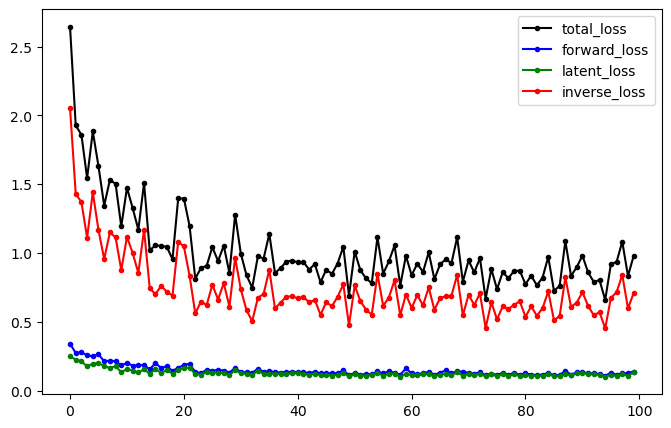

In [11]:
fig, ax = plt.subplots(1, facecolor='white', figsize=(8,5))
ax.plot(hist.history['total_loss'], 'k.-', label='total_loss')
ax.plot(hist.history['forward_loss'], 'b.-', label='forward_loss')
ax.plot(hist.history['latent_loss'], 'g.-', label='latent_loss')
ax.plot(hist.history['rev_loss'], 'r.-', label='inverse_loss')
plt.legend()

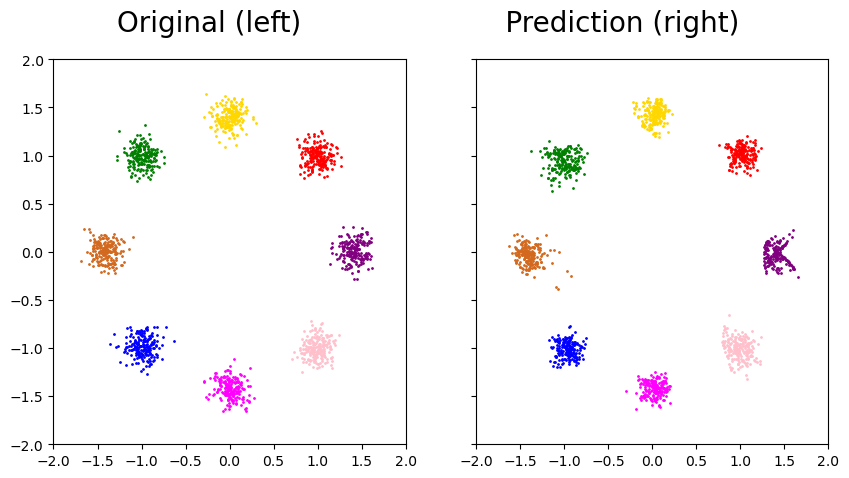

In [12]:
z = np.random.multivariate_normal([0.]*z_dim, np.eye(z_dim), y_onehot.shape[0])
y = np.concatenate([z, y_onehot], axis=-1).astype('float32')
x_pred = model.inverse(y).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), facecolor='white', sharex=True, sharey=True)
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y_onehot.argmax(axis=-1)]
    ax1.scatter(X[idx,0], X[idx,1], s=1, c=color)
    ax2.scatter(x_pred[idx,0], x_pred[idx,1], s=1, c=color)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([-2, 2])
plt.suptitle('Original (left)                       Prediction (right)', fontsize=20);